In [1]:
#sc.stop()
from pyspark import SparkContext

In [2]:
sc = SparkContext(master="local[2]")

22/08/27 04:05:24 WARN Utils: Your hostname, Manojhs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.29.35 instead (on interface en0)
22/08/27 04:05:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/27 04:05:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/27 04:05:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/27 04:05:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/27 04:05:26 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/08/27 04:05:26 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/08/27 04:05:26 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [3]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession

In [6]:
# Spark Session used for DF
spark = SparkSession.builder.appName("MLwithSpark").getOrCreate()

# Preprocessing for test data

In [7]:
df_test = spark.read.csv("crime/test.csv",header=True)

In [8]:
df_test.show(20)

+---+-------------------+---------+----------+--------------------+-------------------+------------------+
| Id|              Dates|DayOfWeek|PdDistrict|             Address|                  X|                 Y|
+---+-------------------+---------+----------+--------------------+-------------------+------------------+
|  0|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...|-122.39958770418998|  37.7350510103906|
|  1|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|  -122.391522893042|  37.7324323864471|
|  2|2015-05-10 23:50:00|   Sunday|  NORTHERN|2000 Block of GOU...|  -122.426001954961|  37.7922124386284|
|  3|2015-05-10 23:45:00|   Sunday| INGLESIDE|4700 Block of MIS...|  -122.437393972517|  37.7214120621391|
|  4|2015-05-10 23:45:00|   Sunday| INGLESIDE|4700 Block of MIS...|  -122.437393972517|  37.7214120621391|
|  5|2015-05-10 23:40:00|   Sunday|   TARAVAL|BROAD ST / CAPITO...|-122.45902362242902|  37.7131719025215|
|  6|2015-05-10 23:30:00|   Sunday| I

In [9]:
df_test.dtypes

[('Id', 'string'),
 ('Dates', 'string'),
 ('DayOfWeek', 'string'),
 ('PdDistrict', 'string'),
 ('Address', 'string'),
 ('X', 'string'),
 ('Y', 'string')]

In [10]:
df_test.dropDuplicates().show()

+----+-------------------+---------+----------+--------------------+-------------------+------------------+
|  Id|              Dates|DayOfWeek|PdDistrict|             Address|                  X|                 Y|
+----+-------------------+---------+----------+--------------------+-------------------+------------------+
| 454|2015-05-09 18:34:00| Saturday|  SOUTHERN|900 Block of HOWA...|-122.40650848700301|  37.7803313209065|
| 540|2015-05-09 14:15:00| Saturday|   CENTRAL| FRONT ST / GREEN ST|  -122.400252662923|  37.8006075195541|
| 620|2015-05-09 10:00:00| Saturday|TENDERLOIN|TURK ST / LEAVENW...|  -122.414056291891|  37.7827931071006|
|1032|2015-05-08 10:00:00|   Friday|   BAYVIEW|1400 Block of SIL...|   -122.40804870235| 37.73175041425571|
|1140|2015-05-07 23:00:00| Thursday|   TARAVAL|RALSTON ST / GARF...|-122.46894994470101|  37.7196568106946|
|1164|2015-05-07 21:45:00| Thursday|TENDERLOIN|HYDE ST / MCALLIS...|-122.41531796699199|  37.7807179285998|
|1250|2015-05-07 18:27:00| T

In [11]:
df_test=df_test.drop('Id','Address')
df_test.show()

+-------------------+---------+----------+-------------------+------------------+
|              Dates|DayOfWeek|PdDistrict|                  X|                 Y|
+-------------------+---------+----------+-------------------+------------------+
|2015-05-10 23:59:00|   Sunday|   BAYVIEW|-122.39958770418998|  37.7350510103906|
|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  -122.391522893042|  37.7324323864471|
|2015-05-10 23:50:00|   Sunday|  NORTHERN|  -122.426001954961|  37.7922124386284|
|2015-05-10 23:45:00|   Sunday| INGLESIDE|  -122.437393972517|  37.7214120621391|
|2015-05-10 23:45:00|   Sunday| INGLESIDE|  -122.437393972517|  37.7214120621391|
|2015-05-10 23:40:00|   Sunday|   TARAVAL|-122.45902362242902|  37.7131719025215|
|2015-05-10 23:30:00|   Sunday| INGLESIDE|-122.42561645123001| 37.73935051446279|
|2015-05-10 23:30:00|   Sunday| INGLESIDE|-122.41265203979201|37.739750156312105|
|2015-05-10 23:10:00|   Sunday|   MISSION|  -122.418700097043|  37.7651649409646|
|2015-05-10 23:1

In [12]:
#Convert non numerical to numerical
from pyspark.sql.functions import *
from itertools import chain

pddis={'MISSION':1,'BAYVIEW':2,'CENTRAL':3,'TARAVAL':4, 'TENDERLOIN':5,'INGLESIDE':6, 'PARK':7,'SOUTHERN':8, 'RICHMOND':9,'NORTHERN':10}
mapping_expr2 = create_map([lit(x) for x in chain(*pddis.items())])
df_test=df_test.withColumn("District", mapping_expr2.getItem(col("PdDistrict")))

from pyspark.ml.feature import StringIndexer 
index= StringIndexer(inputCol="DayOfWeek" , outputCol="DayofWeek")
df_test= index.fit(df_test).transform(df_test)
df_test.show()

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-------------------+---------+----------+-------------------+------------------+--------+
|              Dates|DayofWeek|PdDistrict|                  X|                 Y|District|
+-------------------+---------+----------+-------------------+------------------+--------+
|2015-05-10 23:59:00|      6.0|   BAYVIEW|-122.39958770418998|  37.7350510103906|       2|
|2015-05-10 23:51:00|      6.0|   BAYVIEW|  -122.391522893042|  37.7324323864471|       2|
|2015-05-10 23:50:00|      6.0|  NORTHERN|  -122.426001954961|  37.7922124386284|      10|
|2015-05-10 23:45:00|      6.0| INGLESIDE|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:45:00|      6.0| INGLESIDE|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:40:00|      6.0|   TARAVAL|-122.45902362242902|  37.7131719025215|       4|
|2015-05-10 23:30:00|      6.0| INGLESIDE|-122.42561645123001| 37.73935051446279|       6|
|2015-05-10 23:30:00|      6.0| INGLESIDE|-122.41265203979201|37.739750156312105|       6|

In [13]:
from pyspark.sql.types import DoubleType
df_test = df_test.withColumn("X", df_test["X"].cast(DoubleType()))
df_test = df_test.withColumn("Y", df_test["Y"].cast(DoubleType()))
df_test.show()

+-------------------+---------+----------+-------------------+------------------+--------+
|              Dates|DayofWeek|PdDistrict|                  X|                 Y|District|
+-------------------+---------+----------+-------------------+------------------+--------+
|2015-05-10 23:59:00|      6.0|   BAYVIEW|-122.39958770418998|  37.7350510103906|       2|
|2015-05-10 23:51:00|      6.0|   BAYVIEW|  -122.391522893042|  37.7324323864471|       2|
|2015-05-10 23:50:00|      6.0|  NORTHERN|  -122.426001954961|  37.7922124386284|      10|
|2015-05-10 23:45:00|      6.0| INGLESIDE|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:45:00|      6.0| INGLESIDE|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:40:00|      6.0|   TARAVAL|-122.45902362242902|  37.7131719025215|       4|
|2015-05-10 23:30:00|      6.0| INGLESIDE|-122.42561645123001| 37.73935051446279|       6|
|2015-05-10 23:30:00|      6.0| INGLESIDE|-122.41265203979201|37.739750156312105|       6|

In [14]:
df_test=df_test.drop('PdDistrict')
df_test.show()

+-------------------+---------+-------------------+------------------+--------+
|              Dates|DayofWeek|                  X|                 Y|District|
+-------------------+---------+-------------------+------------------+--------+
|2015-05-10 23:59:00|      6.0|-122.39958770418998|  37.7350510103906|       2|
|2015-05-10 23:51:00|      6.0|  -122.391522893042|  37.7324323864471|       2|
|2015-05-10 23:50:00|      6.0|  -122.426001954961|  37.7922124386284|      10|
|2015-05-10 23:45:00|      6.0|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:45:00|      6.0|  -122.437393972517|  37.7214120621391|       6|
|2015-05-10 23:40:00|      6.0|-122.45902362242902|  37.7131719025215|       4|
|2015-05-10 23:30:00|      6.0|-122.42561645123001| 37.73935051446279|       6|
|2015-05-10 23:30:00|      6.0|-122.41265203979201|37.739750156312105|       6|
|2015-05-10 23:10:00|      6.0|  -122.418700097043|  37.7651649409646|       1|
|2015-05-10 23:10:00|      6.0|  -122.41

In [15]:
df_test.dtypes

[('Dates', 'string'),
 ('DayofWeek', 'double'),
 ('X', 'double'),
 ('Y', 'double'),
 ('District', 'int')]

In [16]:
import pyspark.sql.functions as F
split_col = pyspark.sql.functions.split(df_test['Dates'], ' ')
df_test = df_test.withColumn('Date', split_col.getItem(0))
df_test = df_test.withColumn('Time', split_col.getItem(1))

In [17]:
split_col = pyspark.sql.functions.split(df_test['Date'], '-')
df_test = df_test.withColumn('Year', split_col.getItem(0))
df_test = df_test.withColumn('Month', split_col.getItem(1))
df_test = df_test.withColumn('Day', split_col.getItem(2))
split_col = pyspark.sql.functions.split(df_test['Time'], ':')
df_test = df_test.withColumn('Hours', split_col.getItem(0))
df_test = df_test.withColumn('Mins', split_col.getItem(1))
df_test = df_test.withColumn('Secs', split_col.getItem(2))
df_test.show()

+-------------------+---------+-------------------+------------------+--------+----------+--------+----+-----+---+-----+----+----+
|              Dates|DayofWeek|                  X|                 Y|District|      Date|    Time|Year|Month|Day|Hours|Mins|Secs|
+-------------------+---------+-------------------+------------------+--------+----------+--------+----+-----+---+-----+----+----+
|2015-05-10 23:59:00|      6.0|-122.39958770418998|  37.7350510103906|       2|2015-05-10|23:59:00|2015|   05| 10|   23|  59|  00|
|2015-05-10 23:51:00|      6.0|  -122.391522893042|  37.7324323864471|       2|2015-05-10|23:51:00|2015|   05| 10|   23|  51|  00|
|2015-05-10 23:50:00|      6.0|  -122.426001954961|  37.7922124386284|      10|2015-05-10|23:50:00|2015|   05| 10|   23|  50|  00|
|2015-05-10 23:45:00|      6.0|  -122.437393972517|  37.7214120621391|       6|2015-05-10|23:45:00|2015|   05| 10|   23|  45|  00|
|2015-05-10 23:45:00|      6.0|  -122.437393972517|  37.7214120621391|       6|2015

In [18]:
df_test=df_test.drop('Dates','Time','Date')

In [19]:
df_test.show()

+---------+-------------------+------------------+--------+----+-----+---+-----+----+----+
|DayofWeek|                  X|                 Y|District|Year|Month|Day|Hours|Mins|Secs|
+---------+-------------------+------------------+--------+----+-----+---+-----+----+----+
|      6.0|-122.39958770418998|  37.7350510103906|       2|2015|   05| 10|   23|  59|  00|
|      6.0|  -122.391522893042|  37.7324323864471|       2|2015|   05| 10|   23|  51|  00|
|      6.0|  -122.426001954961|  37.7922124386284|      10|2015|   05| 10|   23|  50|  00|
|      6.0|  -122.437393972517|  37.7214120621391|       6|2015|   05| 10|   23|  45|  00|
|      6.0|  -122.437393972517|  37.7214120621391|       6|2015|   05| 10|   23|  45|  00|
|      6.0|-122.45902362242902|  37.7131719025215|       4|2015|   05| 10|   23|  40|  00|
|      6.0|-122.42561645123001| 37.73935051446279|       6|2015|   05| 10|   23|  30|  00|
|      6.0|-122.41265203979201|37.739750156312105|       6|2015|   05| 10|   23|  30|  00|

In [20]:
df_test.dtypes

[('DayofWeek', 'double'),
 ('X', 'double'),
 ('Y', 'double'),
 ('District', 'int'),
 ('Year', 'string'),
 ('Month', 'string'),
 ('Day', 'string'),
 ('Hours', 'string'),
 ('Mins', 'string'),
 ('Secs', 'string')]

In [21]:
#normalize X and Y
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.functions import vector_to_array

vector_assembler = VectorAssembler(inputCols=['X','Y'], outputCol="SS_features")
indexed = vector_assembler.transform(df_test)
minmax_scaler = MinMaxScaler(inputCol="SS_features", outputCol="scaled")
scaled = minmax_scaler.fit(indexed).transform(indexed)
scaled=scaled.withColumn("s", vector_to_array("scaled")).select(['DayofWeek','District','Year','Month','Day','Hours','Mins']+[col("s")[i] for i in range(2)])


In [22]:
df_test= scaled
from pyspark.sql.types import IntegerType
df_test=df_test.withColumn("Year",df_test.Year.cast(IntegerType()))
df_test=df_test.withColumn("Month",df_test.Month.cast(IntegerType()))
df_test=df_test.withColumn("Day",df_test.Day.cast(IntegerType()))
df_test=df_test.withColumn("Hours",df_test.Hours.cast(IntegerType()))
df_test=df_test.withColumn("Mins",df_test.Mins.cast(IntegerType()))

df_test.show()

+---------+--------+----+-----+---+-----+----+--------------------+--------------------+
|DayofWeek|District|Year|Month|Day|Hours|Mins|                s[0]|                s[1]|
+---------+--------+----+-----+---+-----+----+--------------------+--------------------+
|      6.0|       2|2015|    5| 10|   23|  59| 0.05664083112021621|5.196191600020373E-4|
|      6.0|       2|2015|    5| 10|   23|  51| 0.06064591786875534|4.695423244378389...|
|      6.0|      10|2015|    5| 10|   23|  50| 0.04352318164345805|0.001612736577486...|
|      6.0|       6|2015|    5| 10|   23|  45| 0.03786576230462328|2.587969176351025E-4|
|      6.0|       6|2015|    5| 10|   23|  45| 0.03786576230462328|2.587969176351025E-4|
|      6.0|       4|2015|    5| 10|   23|  40|0.027124205850476944|1.012175449963117...|
|      6.0|       6|2015|    5| 10|   23|  30| 0.04371462764958716|6.018400374844448E-4|
|      6.0|       6|2015|    5| 10|   23|  30| 0.05015291758597506|6.094825243800206E-4|
|      6.0|       1|2

In [23]:
pandasDF = df_test.toPandas()

In [24]:
pandasDF.reset_index()

,index,DayofWeek,District,Year,Month,Day,Hours,Mins,s[0],s[1]
0,0,6.0,2,2015,5,10,23,59,0.056641,0.000520
1,1,6.0,2,2015,5,10,23,51,0.060646,0.000470
2,2,6.0,10,2015,5,10,23,50,0.043523,0.001613
3,3,6.0,6,2015,5,10,23,45,0.037866,0.000259
4,4,6.0,6,2015,5,10,23,45,0.037866,0.000259
...,...,...,...,...,...,...,...,...,...,...
884257,884257,1.0,1,2003,1,1,0,1,0.051975,0.000843
884258,884258,1.0,10,2003,1,1,0,1,0.043851,0.001622
884259,884259,1.0,6,2003,1,1,0,1,0.033881,0.000080
884260,884260,1.0,2,2003,1,1,0,1,0.062696,0.000604


In [25]:
df_test3 = pandasDF
from sklearn.model_selection import train_test_split
#test,_ = train_test_split(df_test3, test_size=0)
f=['District','s[0]','s[1]','Hours','Year','Month','Day','Mins']
test=df_test3[f].values
print(test)


[[2.00000000e+00 5.66408311e-02 5.19619160e-04 ... 5.00000000e+00
  1.00000000e+01 5.90000000e+01]
 [2.00000000e+00 6.06459179e-02 4.69542324e-04 ... 5.00000000e+00
  1.00000000e+01 5.10000000e+01]
 [1.00000000e+01 4.35231816e-02 1.61273658e-03 ... 5.00000000e+00
  1.00000000e+01 5.00000000e+01]
 ...
 [6.00000000e+00 3.38808181e-02 8.02372156e-05 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [2.00000000e+00 6.26963170e-02 6.04302260e-04 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [4.00000000e+00 1.18829933e-02 4.98559729e-04 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


# preprocessing for training data

In [26]:
df_training = spark.read.csv("crime/train.csv",header=True)

df_training.show(20)

df_training.dtypes

df_training.dropDuplicates().show()

df_training=df_training.drop('Descript','Resolution','Address')
df_training.show()

#Convert non numerical to numerical
from pyspark.sql.functions import *
from itertools import chain
data_dict = {'FRAUD':1, 'SUICIDE':2, 'SEX OFFENSES FORCIBLE':3, 'LIQUOR LAWS':4, 
'SECONDARY CODES':5, 'FAMILY OFFENSES':6, 'MISSING PERSON':7, 'OTHER OFFENSES':8, 
'DRIVING UNDER THE INFLUENCE':9, 'WARRANTS':10, 'ARSON':11, 'SEX OFFENSES NON FORCIBLE':12,
'FORGERY/COUNTERFEITING':13, 'GAMBLING':14, 'BRIBERY':15, 'ASSAULT':16, 'DRUNKENNESS':17,
'EXTORTION':18, 'TREA':19, 'WEAPON LAWS':20, 'LOITERING':21, 'SUSPICIOUS OCC':22, 
'ROBBERY':23, 'PROSTITUTION':24, 'EMBEZZLEMENT':25, 'BAD CHECKS':26, 'DISORDERLY CONDUCT':27,
'RUNAWAY':28, 'RECOVERED VEHICLE':29, 'VANDALISM':30,'DRUG/NARCOTIC':31, 
'PORNOGRAPHY/OBSCENE MAT':32, 'TRESPASS':33,'VEHICLE THEFT':34, 'NON-CRIMINAL':35, 
'STOLEN PROPERTY':36, 'LARCENY/THEFT':37, 'KIDNAPPING':38,'BURGLARY':39}

mapping_expr1 = create_map([lit(x) for x in chain(*data_dict.items())])
df_training=df_training.withColumn("category", mapping_expr1.getItem(col("Category")))

pddis={'MISSION':1,'BAYVIEW':2,'CENTRAL':3,'TARAVAL':4, 'TENDERLOIN':5,'INGLESIDE':6, 'PARK':7,'SOUTHERN':8, 'RICHMOND':9,'NORTHERN':10}
mapping_expr2 = create_map([lit(x) for x in chain(*pddis.items())])
df_training=df_training.withColumn("District", mapping_expr2.getItem(col("PdDistrict")))

from pyspark.ml.feature import StringIndexer 
# indexer = StringIndexer(inputCol="Category" , outputCol="category")
# df_training= indexer.fit(df_training).transform(df_training)
index= StringIndexer(inputCol="DayOfWeek" , outputCol="DayofWeek")
df_training= index.fit(df_training).transform(df_training)
# index= StringIndexer(inputCol="PdDistrict" , outputCol="District")
# df_training= index.fit(df_training).transform(df_training)
df_training.show()

from pyspark.sql.types import DoubleType
df_training = df_training.withColumn("X", df_training["X"].cast(DoubleType()))
df_training = df_training.withColumn("Y", df_training["Y"].cast(DoubleType()))
df_training.show()

df_training=df_training.drop('PdDistrict')
df_training.show()

df_training.dtypes

cat=df_training.groupby('category').count()
cat.orderBy("category").show()

df_training.groupby('District').count().show()

import pyspark.sql.functions as F
split_col = pyspark.sql.functions.split(df_training['Dates'], ' ')
df_training = df_training.withColumn('Date', split_col.getItem(0))
df_training = df_training.withColumn('Time', split_col.getItem(1))

split_col = pyspark.sql.functions.split(df_training['Date'], '-')
df_training = df_training.withColumn('Year', split_col.getItem(0))
df_training = df_training.withColumn('Month', split_col.getItem(1))
df_training = df_training.withColumn('Day', split_col.getItem(2))
split_col = pyspark.sql.functions.split(df_training['Time'], ':')
df_training = df_training.withColumn('Hours', split_col.getItem(0))
df_training = df_training.withColumn('Mins', split_col.getItem(1))
df_training = df_training.withColumn('Secs', split_col.getItem(2))
df_training.show()

df_training=df_training.drop('Dates','Time','Date')

df_training.show()

df_training.dtypes

#normalize X and Y
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.functions import vector_to_array

vector_assembler = VectorAssembler(inputCols=['X','Y'], outputCol="SS_features")
indexed = vector_assembler.transform(df_training)
minmax_scaler = MinMaxScaler(inputCol="SS_features", outputCol="scaled")
scaled = minmax_scaler.fit(indexed).transform(indexed)
scaled=scaled.withColumn("s", vector_to_array("scaled")).select(['DayofWeek','category','District','Year','Month','Day','Hours','Mins']+[col("s")[i] for i in range(2)])


df_training= scaled
from pyspark.sql.types import IntegerType
df_training=df_training.withColumn("Year",df_training.Year.cast(IntegerType()))
df_training=df_training.withColumn("Month",df_training.Month.cast(IntegerType()))
df_training=df_training.withColumn("Day",df_training.Day.cast(IntegerType()))
df_training=df_training.withColumn("Hours",df_training.Hours.cast(IntegerType()))
df_training=df_training.withColumn("Mins",df_training.Mins.cast(IntegerType()))

df_training.show()

df_training = df_training.drop('Secs')
df_training.dtypes

pandasDF = df_training.toPandas()

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|       Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+---------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 19:30:00|  LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  SOUTHERN|          NONE|500 Block of BRAN...|  -122.397615567933|  37.7773918242817|
|2015-05-12 22:00:00|SECONDARY CODES|   ATM RELATED CRIME|  Tuesday|   CENTRAL|          NONE|1400 Block of STO...|-122.40903150597099|  37.7992531925554|
|2015-05-12 20:45:00|  LARCENY/THEFT|GRAND THEFT FROM ...|  Tuesday| INGLESIDE|          NONE|0 Block of FRANCO...|  -122.408262089626| 37.74677963933061|
|2015-05-12 10:00:00| MISSING PERSON|       MISSING ADULT|  Tuesday|  

+-------------------+--------+---------+----------+-------------------+------------------+--------+
|              Dates|category|DayofWeek|PdDistrict|                  X|                 Y|District|
+-------------------+--------+---------+----------+-------------------+------------------+--------+
|2015-05-13 23:53:00|      10|      1.0|  NORTHERN|  -122.425891675136|  37.7745985956747|      10|
|2015-05-13 23:53:00|       8|      1.0|  NORTHERN|  -122.425891675136|  37.7745985956747|      10|
|2015-05-13 23:33:00|       8|      1.0|  NORTHERN|   -122.42436302145|  37.8004143219856|      10|
|2015-05-13 23:30:00|      37|      1.0|  NORTHERN|-122.42699532676599| 37.80087263276921|      10|
|2015-05-13 23:30:00|      37|      1.0|      PARK|  -122.438737622757|37.771541172057795|       7|
|2015-05-13 23:30:00|      37|      1.0| INGLESIDE|-122.40325236121201|   37.713430704116|       6|
|2015-05-13 23:30:00|      34|      1.0| INGLESIDE|  -122.423326976668|  37.7251380403778|       6|


+--------+------+
|category| count|
+--------+------+
|       1| 16679|
|       2|   508|
|       3|  4388|
|       4|  1903|
|       5|  9985|
|       6|   491|
|       7| 25989|
|       8|126182|
|       9|  2268|
|      10| 42214|
|      11|  1513|
|      12|   148|
|      13| 10609|
|      14|   146|
|      15|   289|
|      16| 76876|
|      17|  4280|
|      18|   256|
|      19|     6|
|      20|  8555|
+--------+------+
only showing top 20 rows



+--------+------+
|District| count|
+--------+------+
|       1|119908|
|       6| 78845|
|       3| 85460|
|       5| 81809|
|       9| 45209|
|       4| 65596|
|       8|157182|
|       7| 49313|
|      10|105296|
|       2| 89431|
+--------+------+

+-------------------+--------+---------+-------------------+------------------+--------+----------+--------+----+-----+---+-----+----+----+
|              Dates|category|DayofWeek|                  X|                 Y|District|      Date|    Time|Year|Month|Day|Hours|Mins|Secs|
+-------------------+--------+---------+-------------------+------------------+--------+----------+--------+----+-----+---+-----+----+----+
|2015-05-13 23:53:00|      10|      1.0|  -122.425891675136|  37.7745985956747|      10|2015-05-13|23:53:00|2015|   05| 13|   23|  53|  00|
|2015-05-13 23:53:00|       8|      1.0|  -122.425891675136|  37.7745985956747|      10|2015-05-13|23:53:00|2015|   05| 13|   23|  53|  00|
|2015-05-13 23:33:00|       8|      1.0|   -122

+---------+--------+--------+----+-----+---+-----+----+--------------------+--------------------+
|DayofWeek|category|District|Year|Month|Day|Hours|Mins|                s[0]|                s[1]|
+---------+--------+--------+----+-----+---+-----+----+--------------------+--------------------+
|      1.0|      10|      10|2015|    5| 13|   23|  53| 0.04357794799292515|0.001275901072932...|
|      1.0|       8|      10|2015|    5| 13|   23|  53| 0.04357794799292515|0.001275901072932...|
|      1.0|       8|      10|2015|    5| 13|   23|  33| 0.04433709665847194|0.001769583980190...|
|      1.0|      37|      10|2015|    5| 13|   23|  30| 0.04302986069898061|0.001778348413053...|
|      1.0|      37|       7|2015|    5| 13|   23|  30| 0.03719848867946867|0.001217432922095...|
|      1.0|      37|       6|2015|    5| 13|   23|  30|0.054820916306646504|1.061666958370074...|
|      1.0|      34|       6|2015|    5| 13|   23|  30|0.044851609540570096|3.300500657010469E-4|
|      1.0|      34|

In [27]:
pandasDF.reset_index()

,index,DayofWeek,category,District,Year,Month,Day,Hours,Mins,s[0],s[1]
0,0,1.0,10,10,2015,5,13,23,53,0.043578,0.001276
1,1,1.0,8,10,2015,5,13,23,53,0.043578,0.001276
2,2,1.0,8,10,2015,5,13,23,33,0.044337,0.001770
3,3,1.0,37,10,2015,5,13,23,30,0.043030,0.001778
4,4,1.0,37,7,2015,5,13,23,30,0.037198,0.001217
...,...,...,...,...,...,...,...,...,...,...,...
878044,878044,5.0,23,4,2003,1,6,0,15,0.027120,0.000118
878045,878045,5.0,37,6,2003,1,6,0,1,0.032915,0.000460
878046,878046,5.0,37,8,2003,1,6,0,1,0.054752,0.001384
878047,878047,5.0,30,8,2003,1,6,0,1,0.061138,0.001391


In [28]:
df3 = pandasDF
from sklearn.model_selection import train_test_split
train, _ = train_test_split(df3)
f=['District','s[0]','s[1]','Hours','Year','Month','Day','Mins']
X_train=train[f].values
y_train=train['category'].values


# Stochastic Gradient Descent Classifier

In [29]:
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
sgdmodel = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.1, l1_ratio=0.15, fit_intercept=True, random_state=20, learning_rate='adaptive',eta0=0.01)
import numpy as np
classes=np.arange(1.0,40.0)
sgdmodel.partial_fit(X_train,y_train,classes=classes)

y_pred_sgd = sgdmodel.predict(test)
print(y_pred_sgd)

[32. 32. 32. ... 32. 32. 32.]


# Multinomial Naive Bayes

In [30]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
import numpy as np
classes=np.arange(1.0,40.0)
mnb.partial_fit(X_train,y_train,classes=classes)

y_pred_mnb =mnb.predict(test)
print(y_pred_mnb)

[31. 31. 31. ... 25. 25. 25.]


# Multi Layer Perceptron

In [31]:
from sklearn.neural_network import MLPClassifier

mlp_gs = MLPClassifier(max_iter=100,activation='tanh',alpha=0.0001)
import numpy as np
classes=np.arange(1.0,40.0)
mlp_gs.partial_fit(X_train,y_train,classes=classes)

y_pred_mlp = mlp_gs.predict(test)
print(y_pred_mlp)

[37. 37. 37. ... 37. 37. 37.]


884262


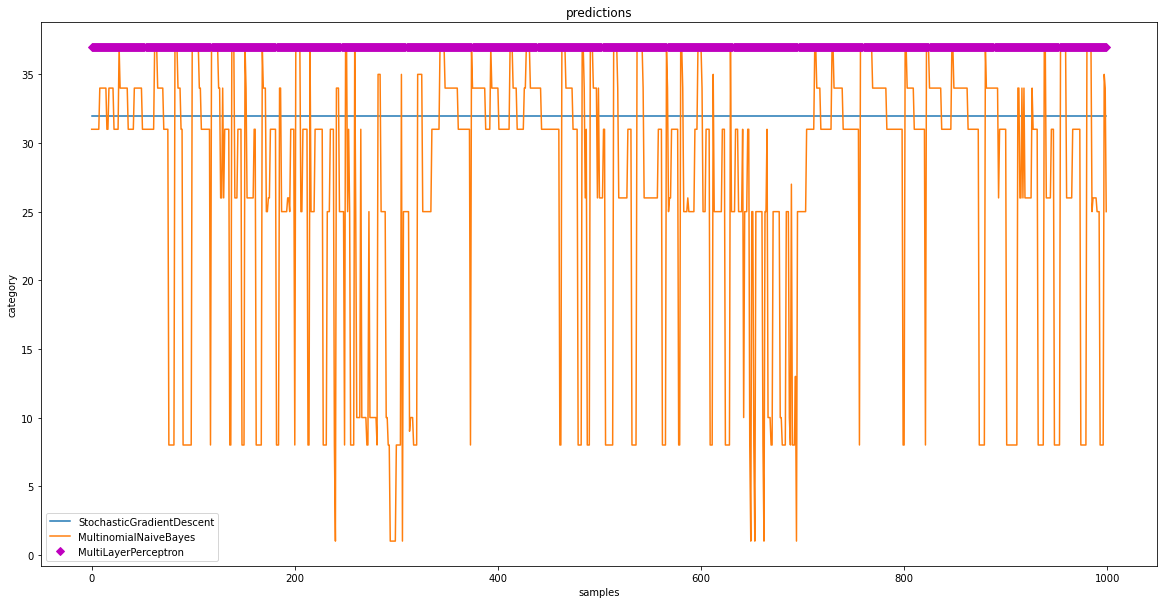

In [37]:
import matplotlib.pyplot as plt
print(len(y_pred_sgd))
x_axis = list(range(len(y_pred_sgd[0:1000])))

# plotting the points
fig = plt.figure(figsize =(20, 10))

plt.plot( y_pred_sgd[0:1000])
plt.plot( y_pred_mnb[0:1000])
plt.plot(y_pred_mlp[0:1000],'Dm')
    
# naming the x axis 
plt.xlabel('samples') 
# naming the y axis 
plt.ylabel('category') 
    
# giving a title to my graph 
plt.title('predictions') 
plt.legend(['StochasticGradientDescent', 'MultinomialNaiveBayes', 'MultiLayerPerceptron'])
# function to show the plot 
plt.show() 
